In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data preprocessing

read file -- > pipeline เปลี่ยน type --> aggegrator

In [2]:
class Pipeline:
    @staticmethod
    # set data types for columns based on their names
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            # P : Transform DPD (Days past due)
            # A : Transform amount
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            # M : Masking categories
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            # D : Transform date
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    # subtracts the date column, converts it to total days, and casts it to Float32.
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    # filters out columns with more than 95% missing values, drops string columns with only one unique value
    # drops string columns with only one unique value or more than 200 unique values
    # drops columns that are not "target", "case_id", or "WEEK_NUM".
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df         [col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [3]:
class Aggregator:
    @staticmethod
    # return list of
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [4]:
# change data type and group by case_id in depth 1,2
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df
# this one is for the one that have multiple sequence name
def read_files(regex_path, depth=None):
    chunks = []
    # glob = global filename
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
    # gather multiple file into one place
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

# Feature engineering 

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            # day of the week 0 for monday, 6 for sunday
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    # function enumerate is used to iterate while keeping the index
    # depth_0, depth_1, depth_2 gonna be a big dictionary      
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [8]:
ROOT            = Path("home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [9]:
# total train file  = 32 but we use only 31 files 
# the left out file is "train_appleprev_2.csv"
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"), 
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"), # 2 files
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),  # 3 files
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1), # 4 files
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2), 
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2), # 11 files
    ]
}

In [16]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


In [17]:
# total test file 36 but we only use only 34 files
# the left out file is "test_appleprev_2.csv" and "test_person_2.csv"
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"), # 3 files 
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1), # 3 files
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1), # 5 files
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2), # 12 files
    ]
}

In [18]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


In [19]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


In [20]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [21]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [22]:
cat_cols

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'max_credacc_status_367L',
 'max_credtype_587L',
 'max_familystate_726L',
 'max_inittransactioncode_279L',
 'max_isbidproduct_390L',
 'max_isdebitcard_527L',
 'max_status_219L',
 'max_classificationofcontr_13M',
 'max_classificationofcontr_400M',
 'max_contractst_545M',


In [41]:
del data_store

gc.collect()

625

In [23]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


In [24]:
b = df_train[["case_id","WEEK_NUM","target"]]
a = df_train["case_id"].value_counts()
a[a>1]
b 



,case_id,WEEK_NUM,target
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,1
...,...,...,...
1526654,2703450,91,0
1526655,2703451,91,0
1526656,2703452,91,0
1526657,2703453,91,0


In [25]:
df_train['target']

0          0
1          0
2          0
3          0
4          1
          ..
1526654    0
1526655    0
1526656    0
1526657    0
1526658    0
Name: target, Length: 1526659, dtype: int64

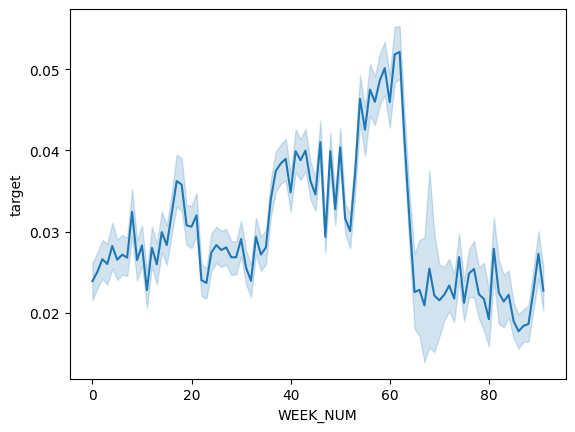

In [26]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()


# Training Model

In [27]:
# This class prepares a voting model from the individual fold level contributions
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0) # หา mean ในแต่ละ column (คำนวณใน row) 
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [28]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
# x.shape (1526659,358)
y = df_train["target"]
# 0 : 1478665 ,1 : 47994 (3.24%)

In [30]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.836989
[200]	valid_0's auc: 0.84626
[300]	valid_0's auc: 0.849643
[400]	valid_0's auc: 0.850922
[500]	valid_0's auc: 0.851649
[600]	valid_0's auc: 0.852131
[700]	valid_0's auc: 0.852327
[800]	valid_0's auc: 0.852499
[900]	valid_0's auc: 0.852843
[1000]	valid_0's auc: 0.853043
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.853052
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.838819
[200]	valid_0's auc: 0.847793
[300]	valid_0's auc: 0.850553
[400]	valid_0's auc: 0.851739
[500]	valid_0's auc: 0.85239
[600]	valid_0's auc: 0.852906
[700]	valid_0's auc: 0.85324
[800]	valid_0's auc: 0.8533
[900]	valid_0's auc: 0.853342
[1000]	valid_0's auc: 0.853496
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.853515
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.843069
[200]	valid_0's auc: 0.852462
[

In [31]:
import joblib

# Load the saved model using joblib
joblib.dump(model, 'Lgbm.joblib')

['Lgbm.joblib']

In [60]:
# Load the saved model using joblib
lgb_loaded_model = joblib.load('Lgbm.joblib')

In [64]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

lgb_y_pred = pd.Series(lgb_loaded_model.predict_proba(X_test)[:, 1], index=X_test.index)

In [71]:
X_test

,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,...,max_subjectroles_name_541M,max_subjectroles_name_838M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_pmts_month_158T,max_pmts_month_706T,max_pmts_year_1139T,max_pmts_year_507T,max_num_group1_13,max_num_group2_13
case_id,,,,,,,,,,,,,,,,,,,,,
57543,5,5,NaN,NaN,NaN,151364.00,-14804.0,2.0,4.0,1.0,...,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2021.0,2018.0,9.0,0.0
57549,1,1,NaN,NaN,NaN,1563077.92,-22723.0,6.0,9.0,3.0,...,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2022.0,2019.0,9.0,0.0
57551,11,5,NaN,NaN,NaN,2926195.30,-14090.0,1.0,3.0,1.0,...,ab3c25cf,ab3c25cf,0.0,75200.0,2.0,2.0,2020.0,2017.0,12.0,0.0
57552,11,5,NaN,NaN,NaN,747031.73,-23768.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57569,12,1,NaN,NaN,NaN,NaN,-26408.0,4.0,4.0,1.0,...,ab3c25cf,a55475b1,NaN,0.0,NaN,10.0,NaN,2019.0,1.0,8.0
57630,3,2,NaN,NaN,NaN,499975.00,-19767.0,1.0,2.0,1.0,...,ab3c25cf,ab3c25cf,0.0,0.0,10.0,10.0,2021.0,2015.0,1.0,8.0
57631,6,6,NaN,NaN,NaN,480334.49,-12999.0,0.0,0.0,0.0,...,ab3c25cf,ab3c25cf,0.0,0.0,10.0,10.0,2019.0,2018.0,1.0,8.0
57632,2,6,NaN,NaN,NaN,17677.00,-23107.0,1.0,2.0,0.0,...,a55475b1,ab3c25cf,0.0,NaN,11.0,NaN,2019.0,NaN,0.0,9.0
57633,1,2,NaN,NaN,NaN,6373008.21,-10496.0,3.0,3.0,2.0,...,ab3c25cf,ab3c25cf,7230000.0,0.0,3.0,3.0,2021.0,2021.0,8.0,1.0


In [ ]:
X

In [34]:
import xgboost as xgb
model = xgb.XGBClassifier(
    device="cuda",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    #learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    #gamma=0.7,
    #reg_alpha=0.7,
    max_depth=20,
    n_estimators=800,
    random_state=42,
)

# Training the model on the training data
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=5,
    verbose=True,
)

print(model)


/Users/kitchaichawmengchai/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72063
[1]	validation_0-auc:0.74838
[2]	validation_0-auc:0.76037
[3]	validation_0-auc:0.76953
[4]	validation_0-auc:0.77552
[5]	validation_0-auc:0.78014
[6]	validation_0-auc:0.78242
[7]	validation_0-auc:0.78608
[8]	validation_0-auc:0.78973
[9]	validation_0-auc:0.79340
[10]	validation_0-auc:0.79624
[11]	validation_0-auc:0.79860
[12]	validation_0-auc:0.80121
[13]	validation_0-auc:0.80348
[14]	validation_0-auc:0.80490
[15]	validation_0-auc:0.80696
[16]	validation_0-auc:0.80872
[17]	validation_0-auc:0.81028
[18]	validation_0-auc:0.81130
[19]	validation_0-auc:0.81175
[20]	validation_0-auc:0.81266
[21]	validation_0-auc:0.81304
[22]	validation_0-auc:0.81337
[23]	validation_0-auc:0.81374
[24]	validation_0-auc:0.81461
[25]	validation_0-auc:0.81521
[26]	validation_0-auc:0.81535
[27]	validation_0-auc:0.81592
[28]	validation_0-auc:0.81612
[29]	validation_0-auc:0.81604
[30]	validation_0-auc:0.81648
[31]	validation_0-auc:0.81662
[32]	validation_0-auc:0.81668
[33]	validation_0-au

In [35]:
joblib.dump(model, 'XGboost.joblib')

['XGboost.joblib']

In [65]:
xg_loaded_model = joblib.load('XGboost.joblib')

In [66]:
xg_y_pred = pd.Series(xg_loaded_model.predict_proba(X_test)[:, 1], index=X_test.index)

In [67]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["lgb_score"] = lgb_y_pred
df_subm["xg_score"] = xg_y_pred

In [68]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head(10)

Check null:  False


,score,lgb_score,xg_score
case_id,,,
57543,0.5,0.008026,0.000158
57549,0.5,0.061721,0.003642
57551,0.5,0.004157,0.000172
57552,0.5,0.017645,0.000044
57569,0.5,0.188840,0.000806
57630,0.5,0.010344,0.000209
57631,0.5,0.082071,0.006509
57632,0.5,0.029849,0.008233
57633,0.5,0.060065,0.000380


In [ ]:
from sklearn.metrics import rov_curve, roc_auc_score